# Prova Substitutiva

## Imports

In [1]:
from google.cloud import bigquery
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

## Carregando os dados

In [2]:
df_092020 = pd.read_csv("assets/PNAD_COVID_092020.csv")
df_102020 = pd.read_csv("assets/PNAD_COVID_102020.csv")
df_112020 = pd.read_csv("assets/PNAD_COVID_112020.csv")

## Renomeando a coluna Mês

In [3]:
df_092020.rename(columns={'V1013': 'Mês'}, inplace=True)
df_102020.rename(columns={'V1013': 'Mês'}, inplace=True)
df_112020.rename(columns={'V1013': 'Mês'}, inplace=True)

## Realizando o merge dos dados

In [4]:
df_merged = pd.concat([df_092020, df_102020, df_112020], ignore_index=True)

## Escolhendo as colunas que serão utilizadas
1. Características dos Moradores:
- A002: Idade;
- A003: Sexo;
- A004: Cor ou Raça;
- A005: Escolaridade;

2. Sintomas:
- B0011: Na semana passada teve febre?
- B0012: Na semana passada teve tosse?
- B0013: Na semana passada teve dor de garganta?
- B0014: Na semana passada teve dificuldade para respirar?
- B0015: Na semana passada teve dor de cabeça?
- B0016: Na semana passada teve dor no peito?
- B0017: Na semana passada teve náusea?
- B0018: Na semana passada teve nariz entupido ou escorrendo?
- B0019: Na semana passada teve fadiga?
- B00110: Na semana passada teve dor nos olhos?
- B00111: Na semana passada teve perda de cheiro ou sabor?
- B00112: Na semana passada teve dor muscular?

3. Características de trabalho das pessoas de 14 anos ou mais de idade:
- C001: Na semana passada, por pelo menos uma hora, trabalhou ou fez algum bico?
- C002: Na semana passada, estava temporariamente afastado de algum trabalho?
- C005: Há quanto tempo está afastado desse trabalho?

## Removendo colunas desnecessárias

In [5]:
columns_to_remove = [
    "RM_RIDE", "V1008", "V1012", "V1016", "Estrato", "UPA", "V1022", "V1023", "V1030", "V1031", "V1032", "posest",
    "CAPITAL", "A006", "A006A", "A006B", "A007", "A007A", "A008", "A009", "B00113", "B008", "B009A", "B009B", "B009C", 
    "B009D", "B009E", "B009F", "B0101", "B0102", "B0103", "B0104", "B0105", "B0106", "B011", "C007F", "C009A", "E001", 
    "E0021", "E0022", "E0023", "E0024", "F002A1", "F002A2", "F002A3", "F002A4", "F002A5",
    "A001", "A001A", "A001B1", "A001B2", "A001B3",
    "B002", "B0031", "B0032", "B0033", "B0034", "B0035", "B0036", "B0037", "B0041", "B0042", "B0043", "B0044", "B0045", 
    "B0046", "B005", "B006", "B007",
    "C003", "C004", "C0051", "C0052", "C0053", "C006", "C007", "C007A", "C007B", "C007C", "C007D", "C007E", "C007E1", 
    "C007E2", "C008", "C009", "C010", "C0101", "C01011", "C01012", "C0102", "C01021", "C01022", "C0103", "C0104", 
    "C011A", "C011A1", "C011A11", "C011A12", "C011A2", "C011A21", "C011A22", "C012", "C013", "C014", "C015", "C016", 
    "C017A",
    "D0011", "D0013", "D0021", "D0023", "D0031", "D0033", "D0041", "D0043", "D0051", "D0053", "D0061", "D0063", 
    "D0071", "D0073", "F001", "F0021", "F0022", "F0061", "F006"
]

df_merged = df_merged.drop(columns=columns_to_remove, axis=1)

## Atualizando o Dataframe com o mapeamento do dicionário do PNAD COVID-19

### Mapeando Códigos para UF

In [6]:
uf_mapping = {
    11: "Rondônia", 12: "Acre", 13: "Amazonas", 14: "Roraima", 15: "Pará",
    16: "Amapá", 17: "Tocantins", 21: "Maranhão", 22: "Piauí", 23: "Ceará",
    24: "Rio Grande do Norte", 25: "Paraíba", 26: "Pernambuco", 27: "Alagoas",
    28: "Sergipe", 29: "Bahia", 31: "Minas Gerais", 32: "Espírito Santo",
    33: "Rio de Janeiro", 35: "São Paulo", 41: "Paraná", 42: "Santa Catarina",
    43: "Rio Grande do Sul", 50: "Mato Grosso do Sul", 51: "Mato Grosso",
    52: "Goiás", 53: "Distrito Federal"
}

df_merged["UF"] = df_merged["UF"].astype(int).map(uf_mapping)

### Mapeando Idade

In [7]:
df_merged = df_merged.rename(columns={"A002": "Idade"})

### Mapeando Sexo

In [8]:
df_merged = df_merged.rename(columns={"A003": "Sexo"})

sexo_mapping = {1: "Homem", 2: "Mulher"}

df_merged["Sexo"] = df_merged["Sexo"].astype(int).map(sexo_mapping)

### Mapeando Cor/Raça

In [9]:
df_merged = df_merged.rename(columns={"A004": "Cor ou Raça"})

cor_raca_mapping = {
    1: "Branca",
    2: "Preta",
    3: "Amarela",
    4: "Parda",
    5: "Indígena",
    9: "Ignorado"
}

df_merged["Cor ou Raça"] = df_merged["Cor ou Raça"].astype(int).map(cor_raca_mapping)

### Mapeando Escolaridade

In [10]:
df_merged = df_merged.rename(columns={"A005": "Escolaridade"})

escolaridade_mapping = {
    1: "Sem instrução",
    2: "Fundamental incompleto",
    3: "Fundamental completo",
    4: "Médio incompleto",
    5: "Médio completo",
    6: "Superior incompleto",
    7: "Superior completo",
    8: "Pós-graduação, mestrado ou doutorado"
}

df_merged["Escolaridade"] = df_merged["Escolaridade"].astype(int).map(escolaridade_mapping)

### Mapeando Sintomas

In [11]:
sintomas_rename = {
    "B0011": "Febre", "B0012": "Tosse", "B0013": "Dor de Garganta", "B0014": "Dificuldade para Respirar",
    "B0015": "Dor de Cabeça", "B0016": "Dor no Peito", "B0017": "Náusea", "B0018": "Nariz Entupido ou Escorrendo",
    "B0019": "Fadiga", "B00110": "Dor nos Olhos", "B00111": "Perda de Cheiro ou Sabor", "B00112": "Dor Muscular"
}

df_merged = df_merged.rename(columns=sintomas_rename)

sintomas_mapping = {
    1: "Sim",
    2: "Não",
    3: "Não sabe",
    9: "Ignorado"
}

for coluna in sintomas_rename.values():
    df_merged[coluna] = df_merged[coluna].astype(int).map(sintomas_mapping)

### Mapeando Comportamento no Trabalho

In [12]:
trabalho_rename = {
    "C001": "Trabalhou",
    "C002": "Afastado",
    "C005": "Tempo Afastado"
}

df_merged = df_merged.rename(columns=trabalho_rename)

binario_mapping = {
    1: "Sim",
    2: "Não"
}

for coluna in ["Trabalhou", "Afastado"]:
    df_merged[coluna] = df_merged[coluna].fillna(-1).astype(int).map(binario_mapping).fillna("Não aplicável")

tempo_afastado_mapping = {
    1: "Menos de 1 mês",
    2: "De 1 mês a menos de 1 ano",
    3: "De 1 ano a menos de 2 anos",
    4: "2 anos ou mais"
}

df_merged["Tempo Afastado"] = df_merged["Tempo Afastado"].fillna(-1).astype(int).map(tempo_afastado_mapping).fillna("Não aplicável")

## Exibindo sample dos dados

In [13]:
df_merged.sample(10)

,Ano,UF,Mês,Idade,Sexo,Cor ou Raça,Escolaridade,Febre,Tosse,Dor de Garganta,...,Dor no Peito,Náusea,Nariz Entupido ou Escorrendo,Fadiga,Dor nos Olhos,Perda de Cheiro ou Sabor,Dor Muscular,Trabalhou,Afastado,Tempo Afastado
1042069,2020,São Paulo,11,69,Mulher,Branca,Fundamental completo,Não,Não,Não,...,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não aplicável
833776,2020,Maranhão,11,14,Mulher,Preta,Fundamental incompleto,Não,Não,Não,...,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não aplicável
606481,2020,Rio de Janeiro,10,81,Mulher,Parda,Fundamental completo,Não,Não,Não,...,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não aplicável
614048,2020,Rio de Janeiro,10,64,Homem,Preta,Fundamental incompleto,Não,Não,Não,...,Não,Não,Não,Não,Não,Não,Não,Não,Sim,Não aplicável
1071361,2020,Santa Catarina,11,42,Mulher,Branca,Fundamental incompleto,Não,Não,Não,...,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não aplicável
8430,2020,Acre,9,44,Homem,Parda,Médio completo,Não,Não,Não,...,Não,Não,Não,Não,Não,Não,Não,Sim,Não aplicável,Não aplicável
917202,2020,Bahia,11,63,Mulher,Parda,Médio incompleto,Não,Não,Não,...,Não,Não,Não,Não,Não,Não,Não,Sim,Não aplicável,Não aplicável
746963,2020,Mato Grosso,10,11,Mulher,Branca,Fundamental incompleto,Não,Não,Não,...,Não,Não,Não,Não,Não,Não,Não,Não aplicável,Não aplicável,Não aplicável
512133,2020,Pernambuco,10,66,Homem,Parda,Fundamental incompleto,Não,Não,Não,...,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não aplicável
1013114,2020,São Paulo,11,42,Homem,Branca,Superior completo,Não,Não,Não,...,Não,Não,Não,Não,Não,Não,Não,Sim,Não aplicável,Não aplicável


In [14]:
df_merged.dtypes

Ano                              int64
UF                              object
Mês                              int64
Idade                            int64
Sexo                            object
Cor ou Raça                     object
Escolaridade                    object
Febre                           object
Tosse                           object
Dor de Garganta                 object
Dificuldade para Respirar       object
Dor de Cabeça                   object
Dor no Peito                    object
Náusea                          object
Nariz Entupido ou Escorrendo    object
Fadiga                          object
Dor nos Olhos                   object
Perda de Cheiro ou Sabor        object
Dor Muscular                    object
Trabalhou                       object
Afastado                        object
Tempo Afastado                  object
dtype: object

## Exportando para um arquivo .csv
Esse arquivo será usado para carregar os dados manualmente no BigQuery.

In [15]:
df_merged.to_csv("assets/PNAD_COVID_LIMPO.csv", index=False, encoding="utf-8")

## Conectando ao BigQuery

In [16]:
client = bigquery.Client(project='pnad-covid-19-454122')

### Visualizando uma amostra dos dados
Esses dados foram carregados manualmente no BigQuery usando o CSV limpo como input.

In [17]:
query = """
SELECT *
FROM `pnad-covid-19-454122.pnad_covid19_dataset.pnad_covid19`
LIMIT 1000
"""

df = client.query(query).to_dataframe()

df.head()

,Ano,UF,Mês,Idade,Sexo,Cor ou Raça,Escolaridade,Febre,Tosse,Dor de Garganta,...,Dor no Peito,Náusea,Nariz Entupido ou Escorrendo,Fadiga,Dor nos Olhos,Perda de Cheiro ou Sabor,Dor Muscular,Trabalhou,Afastado,Tempo Afastado
0,2020,Rondônia,9,36,Homem,Parda,Médio completo,Não,Não,Não,...,Não,Não,Não,Não,Não,Não,Não,Sim,Não aplicável,Não aplicável
1,2020,Rondônia,9,30,Mulher,Parda,Superior completo,Não,Não,Não,...,Não,Não,Não,Não,Não,Não,Não,Sim,Não aplicável,Não aplicável
2,2020,Rondônia,9,13,Homem,Parda,Fundamental incompleto,Não,Não,Não,...,Não,Não,Não,Não,Não,Não,Não,Não aplicável,Não aplicável,Não aplicável
3,2020,Rondônia,9,11,Homem,Parda,Fundamental incompleto,Não,Não,Não,...,Não,Não,Não,Não,Não,Não,Não,Não aplicável,Não aplicável,Não aplicável
4,2020,Rondônia,9,57,Mulher,Branca,Fundamental incompleto,Não,Não,Não,...,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não aplicável


## Análises

### Definindo o DataFrame df_sintomas
Esse DataFrame será reutilizado nas análises.

In [18]:
sintomas_cols = [
    "Febre", "Tosse", "Dor de Garganta", "Dificuldade para Respirar", "Dor de Cabeça",
    "Dor no Peito", "Náusea", "Nariz Entupido ou Escorrendo", "Fadiga", "Dor nos Olhos",
    "Perda de Cheiro ou Sabor", "Dor Muscular"
]

sintomas_query = " + ".join([f"IF(`{col}` = 'Sim', 1, 0)" for col in sintomas_cols])

query = f'''
    SELECT 
        Idade, Sexo, `Cor ou Raça` AS Cor_Raca, Escolaridade, Trabalhou, Afastado, `Tempo Afastado`,
        CASE WHEN ({sintomas_query}) > 0 THEN 'Sim' ELSE 'Não' END AS Possui_Sintomas
    FROM `pnad-covid-19-454122.pnad_covid19_dataset.pnad_covid19`
'''

df = client.query(query).to_dataframe()

df_sintomas = df[df["Possui_Sintomas"] == "Sim"]
df_sintomas.sample(5)

,Idade,Sexo,Cor_Raca,Escolaridade,Trabalhou,Afastado,Tempo Afastado,Possui_Sintomas
978355,58,Homem,Branca,Fundamental completo,Não,Não,Não aplicável,Sim
612263,36,Mulher,Branca,Médio completo,Sim,Não aplicável,Não aplicável,Sim
818665,48,Homem,Branca,Médio completo,Sim,Não aplicável,Não aplicável,Sim
984020,59,Homem,Branca,Fundamental incompleto,Não,Sim,Não aplicável,Sim
535468,32,Homem,Parda,Médio completo,Sim,Não aplicável,Não aplicável,Sim


### Principais Sintomas

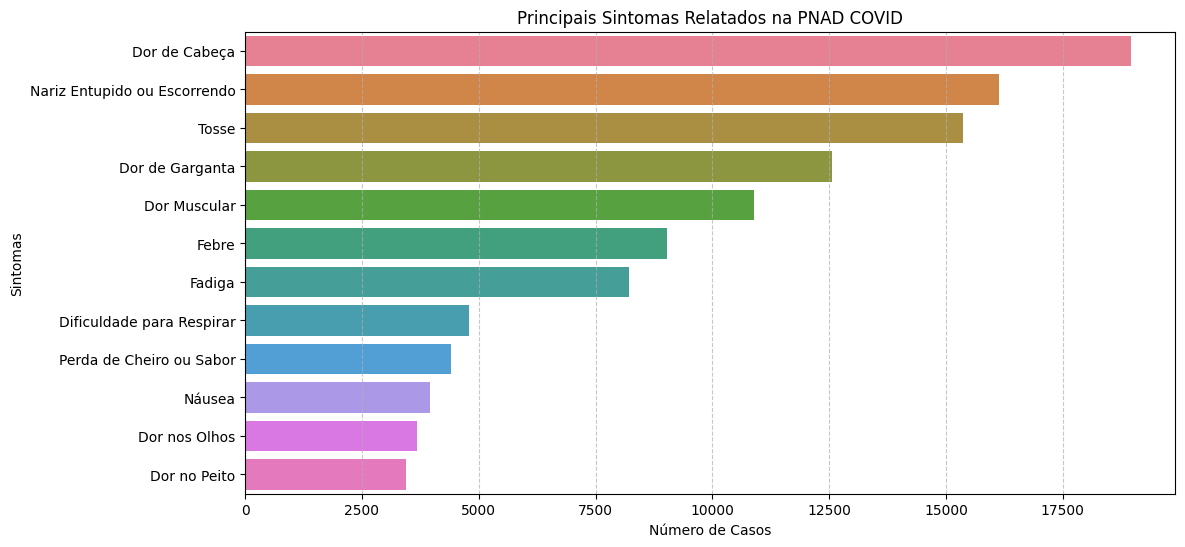

In [19]:
sql_query = f"""
SELECT
  Sintoma,
  COUNTIF(Resposta = 'Sim') AS Frequencia
FROM `pnad-covid-19-454122.pnad_covid19_dataset.pnad_covid19`
UNPIVOT (
  Resposta FOR Sintoma IN (
    `Febre`, 
    `Tosse`, 
    `Dor de Garganta`, 
    `Dificuldade para Respirar`, 
    `Dor de Cabeça`, 
    `Dor no Peito`, 
    `Náusea`, 
    `Nariz Entupido ou Escorrendo`, 
    `Fadiga`, 
    `Dor nos Olhos`, 
    `Perda de Cheiro ou Sabor`, 
    `Dor Muscular`
  )
)
GROUP BY Sintoma
ORDER BY Frequencia DESC;
"""

df_sintomas_principais = client.query(sql_query).to_dataframe()

plt.figure(figsize=(12, 6))
sns.barplot(data=df_sintomas_principais, x="Frequencia", y="Sintoma", hue="Sintoma", dodge=False)
plt.xlabel("Número de Casos")
plt.ylabel("Sintomas")
plt.title("Principais Sintomas Relatados na PNAD COVID")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.legend([],[], frameon=False)  # Remover legenda redundante
plt.show()

### Maior Público Atingido pela Doença

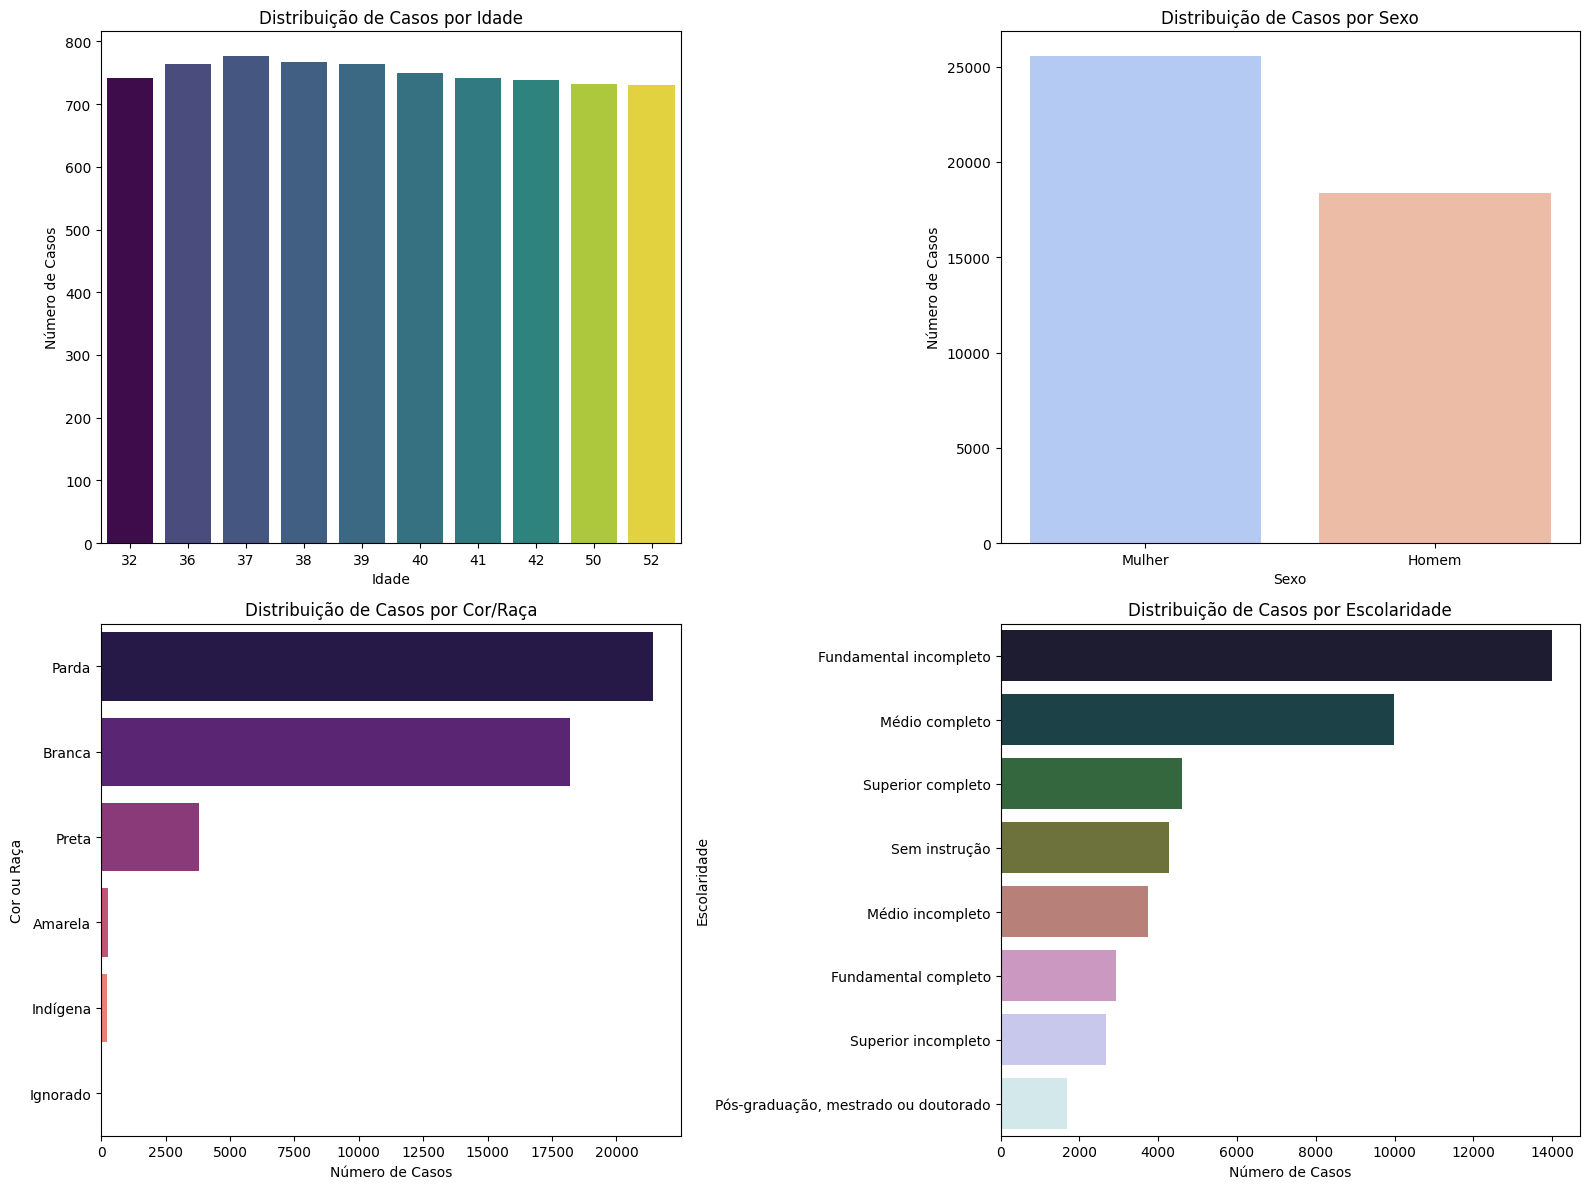

In [20]:
idade_pd = df_sintomas.groupby("Idade").size().reset_index(name="Número de Casos").sort_values(by="Número de Casos", ascending=False)
sexo_pd = df_sintomas.groupby("Sexo").size().reset_index(name="Número de Casos").sort_values(by="Número de Casos", ascending=False)
raca_pd = df_sintomas.groupby("Cor_Raca").size().reset_index(name="Número de Casos").sort_values(by="Número de Casos", ascending=False)
escolaridade_pd = df_sintomas.groupby("Escolaridade").size().reset_index(name="Número de Casos").sort_values(by="Número de Casos", ascending=False)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.barplot(data=idade_pd.head(10), x="Idade", y="Número de Casos", ax=axes[0, 0], palette="viridis", hue="Idade", legend=False)
axes[0, 0].set_title("Distribuição de Casos por Idade")
axes[0, 0].set_xlabel("Idade")
axes[0, 0].set_ylabel("Número de Casos")

sns.barplot(data=sexo_pd, x="Sexo", y="Número de Casos", ax=axes[0, 1], palette="coolwarm", hue="Sexo", legend=False)
axes[0, 1].set_title("Distribuição de Casos por Sexo")
axes[0, 1].set_xlabel("Sexo")
axes[0, 1].set_ylabel("Número de Casos")

sns.barplot(data=raca_pd, x="Número de Casos", y="Cor_Raca", ax=axes[1, 0], palette="magma", hue="Cor_Raca", legend=False)
axes[1, 0].set_title("Distribuição de Casos por Cor/Raça")
axes[1, 0].set_xlabel("Número de Casos")
axes[1, 0].set_ylabel("Cor ou Raça")

sns.barplot(data=escolaridade_pd, x="Número de Casos", y="Escolaridade", ax=axes[1, 1], palette="cubehelix", hue="Escolaridade", legend=False)
axes[1, 1].set_title("Distribuição de Casos por Escolaridade")
axes[1, 1].set_xlabel("Número de Casos")
axes[1, 1].set_ylabel("Escolaridade")

plt.tight_layout()
plt.show()

### Comportamento das Pessoas no Trabalho Presencial

Análise importante para identificarmos potenciais avanços dos casos da doença quando as pessoas continuam indo ao trabalho.

### Comportamento da População

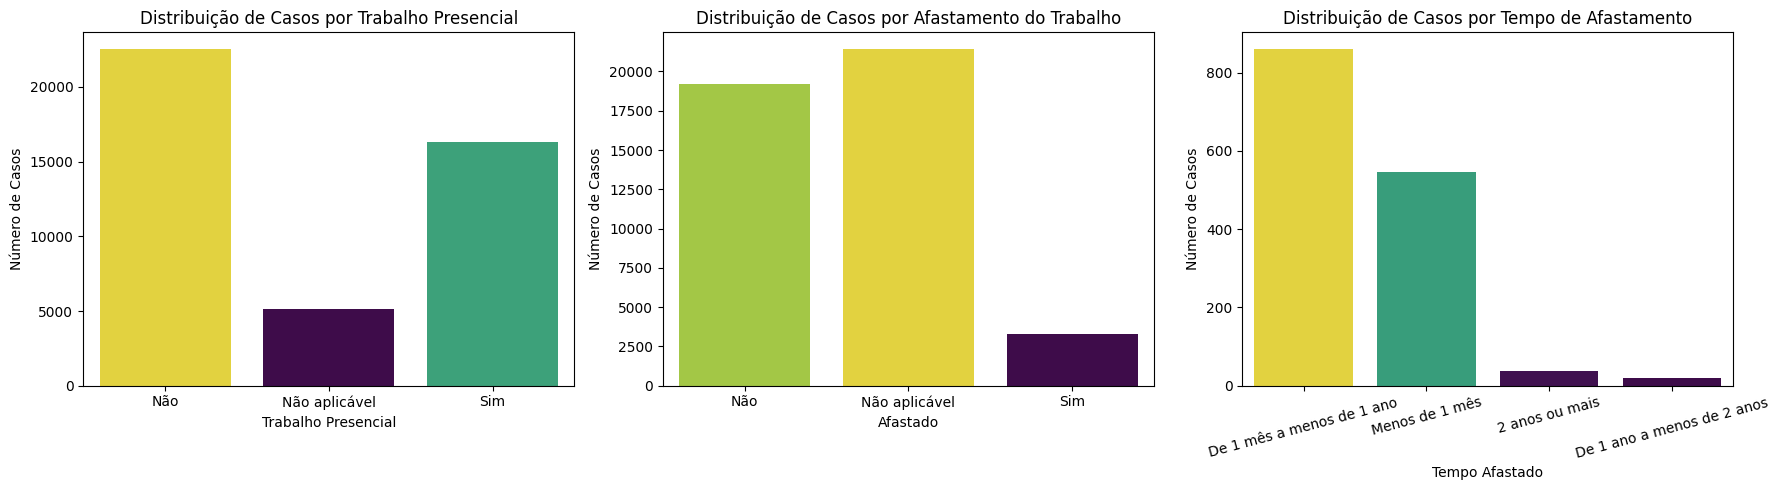

In [21]:
comportamento_pd = df_sintomas.groupby(["Trabalhou", "Afastado", "Tempo Afastado"]).size().reset_index(name="Número de Casos").sort_values(by="Número de Casos", ascending=False)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.barplot(data=comportamento_pd.groupby("Trabalhou").sum().reset_index(),
            x="Trabalhou", y="Número de Casos", hue="Número de Casos", ax=axes[0], palette="viridis", legend=False)
axes[0].set_title("Distribuição de Casos por Trabalho Presencial")
axes[0].set_xlabel("Trabalho Presencial")
axes[0].set_ylabel("Número de Casos")

sns.barplot(data=comportamento_pd.groupby("Afastado").sum().reset_index(),
            x="Afastado", y="Número de Casos", hue="Número de Casos", ax=axes[1], palette="viridis", legend=False)
axes[1].set_title("Distribuição de Casos por Afastamento do Trabalho")
axes[1].set_xlabel("Afastado")
axes[1].set_ylabel("Número de Casos")

sns.barplot(
    data=comportamento_pd[comportamento_pd["Tempo Afastado"] != "Não aplicável"],
    x="Tempo Afastado", 
    y="Número de Casos", 
    hue="Número de Casos", 
    ax=axes[2], 
    palette="viridis", 
    legend=False
)
axes[2].set_title("Distribuição de Casos por Tempo de Afastamento")
axes[2].set_xlabel("Tempo Afastado")
axes[2].set_ylabel("Número de Casos")
axes[2].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

## Clusterização

### Pessoas Infectadas por Idade e Número de Casos (K-Means)

O gráfico de dispersão mostra que os grupos possuem padrões diferentes de incidência da doença. O cluster 0 (roxo) representa indivíduos com um número menor de casos, possivelmente trabalhadores afastados ou com menos exposição. O cluster 1 (verde) concentra casos elevados em uma faixa etária mais avançada, sugerindo maior impacto entre idosos. Já o cluster 2 (amarelo) agrupa casos elevados entre indivíduos mais jovens e de meia-idade, indicando maior exposição ou presença em atividades laborais presenciais. Essa análise pode ser útil para direcionar estratégias de prevenção, controle da doença e políticas de saúde pública com base nos perfis mais afetados.

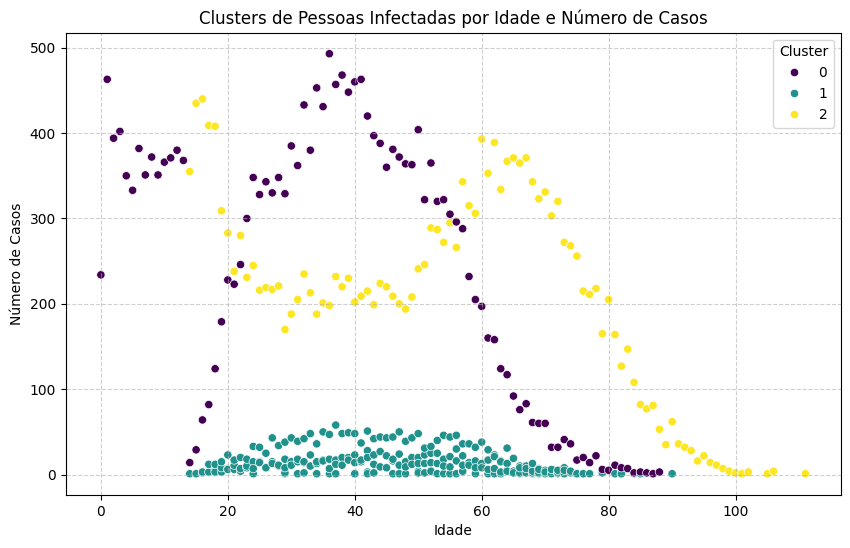

In [22]:
comportamento_pd = df_sintomas.groupby(["Idade", "Trabalhou", "Afastado", "Tempo Afastado"]).size().reset_index(name="Número de Casos")

df_encoded = pd.get_dummies(comportamento_pd, columns=["Trabalhou", "Afastado", "Tempo Afastado"])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded.drop(columns=["Número de Casos"]))

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_encoded["Cluster"] = kmeans.fit_predict(X_scaled)

comportamento_pd["Cluster"] = df_encoded["Cluster"]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=comportamento_pd, x="Idade", y="Número de Casos", hue="Cluster", palette="viridis")

plt.xlabel("Idade")
plt.ylabel("Número de Casos")
plt.title("Clusters de Pessoas Infectadas por Idade e Número de Casos")
plt.legend(title="Cluster")
plt.grid(True, linestyle="--", alpha=0.6)

plt.show()